<a href="https://colab.research.google.com/github/maxwellfundi/AI-Course-2024/blob/main/Njiru_Final_Project_Liver_Segmentation09112024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#extract the Liver_medical_Image_Datasets.zip
import zipfile

with zipfile.ZipFile('/content/Liver_Medical_Image _Datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_liver_images')

Importing libraries

In [3]:
#Setting up imports needed
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [4]:
#setting paths for the images and labels
image_path = '/content/extracted_liver_images/Liver_Medical_Image _Datasets/Images'
label_path = '/content/extracted_liver_images/Liver_Medical_Image _Datasets/Labels'

In [5]:
#loading and preprocess the liver images
images = [cv2.imread(os.path.join(image_path, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(image_path)]
labels = [cv2.imread(os.path.join(label_path, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(label_path)]

#resizing the images to ensure they match the models input shape
images = [cv2.resize(img, (256, 256)) for img in images]
labels = [cv2.resize(lbl, (256, 256)) for lbl in labels]

# Normalize images and labels
images = np.array(images) / 255.0
labels = np.array(labels) / 255.0

# add channel dimension for grayscale
images = np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)

In [6]:
#Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, train_size=360, test_size=40, random_state=42)


In [7]:
#defining the unet model
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#traini the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=None)

Epoch 1/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 2266s 187s/step - accuracy: 0.8065 - loss: 0.6431 - val_accuracy: 0.9021 - val_loss: 0.4209
Epoch 2/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 2295s 187s/step - accuracy: 0.9085 - loss: 0.4372 - val_accuracy: 0.9021 - val_loss: 0.3068
Epoch 3/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 2378s 194s/step - accuracy: 0.9115 - loss: 0.2642 - val_accuracy: 0.9021 - val_loss: 0.2460


In [9]:
#Saving the model
model.save('/content/unet_liver_segmentation_model.h5')


In [10]:
#define evaluation metrics
def mean_iou(y_true, y_pred):
    intersection = np.sum(np.round(y_true * y_pred))
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union != 0 else 0

def mean_pixel_accuracy(y_true, y_pred):
    correct = np.sum(y_true == np.round(y_pred))
    total = y_true.size
    return correct / total


In [11]:
#Evaluate the model
ious, pas = [], []
for x, y in zip(X_val, y_val):
    pred = model.predict(np.expand_dims(x, axis=0))[0]
    ious.append(mean_iou(y, pred))
    pas.append(mean_pixel_accuracy(y, pred))

print(f"mIoU: {np.mean(ious)}")
print(f"mPA: {np.mean(pas)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


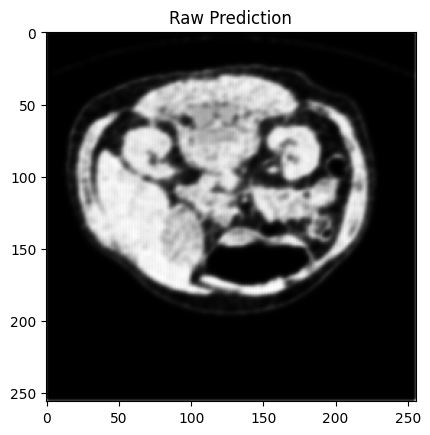

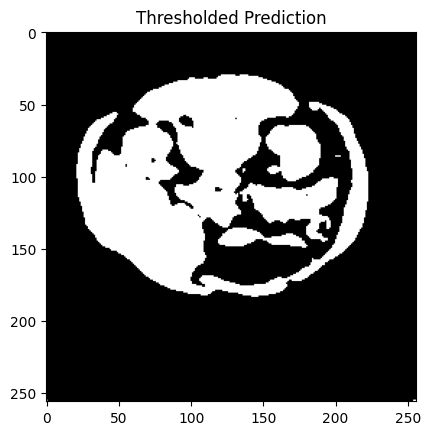

In [48]:
from tensorflow.keras.utils import img_to_array, load_img  # Import necessary functions
import numpy as np
import matplotlib.pyplot as plt

def segment_single_image(model, image_path, save_path):
    # Load image in grayscale (convert if needed)
    img = load_img(image_path, color_mode='grayscale', target_size=(256, 256))

    # Convert to NumPy array
    img = img_to_array(img)

    # Normalize to 0-1 range and  add batch dimension
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict with the model
    pred = model.predict(img)

    # Visualize raw prediction
    plt.figure()
    plt.imshow(pred[0, :, :, 0], cmap='gray')
    plt.title("Raw Prediction")
    plt.show()

    #defining the prediction value
    pred_thresholded = (pred > 0.1).astype(np.uint8)

    #Visualize thresholded prediction
    plt.figure()
    plt.imshow(pred_thresholded[0, :, :, 0], cmap='gray')
    plt.title("Thresholded Prediction")
    plt.show()

    # Extract segmented image
    segmented_img = pred_thresholded[0, :, :, 0]

    # Save segmented image
    plt.imsave(save_path, segmented_img, cmap='gray')


segment_single_image(model, '/content/extracted_liver_images/Liver_Medical_Image _Datasets/Images/200.png', 'segmented_liver.jpg')

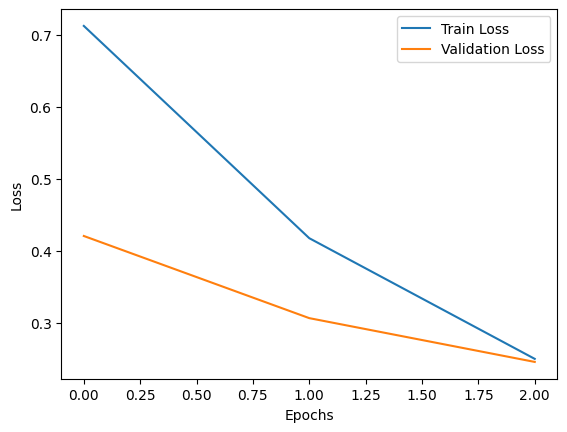

In [21]:
#Visualise the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


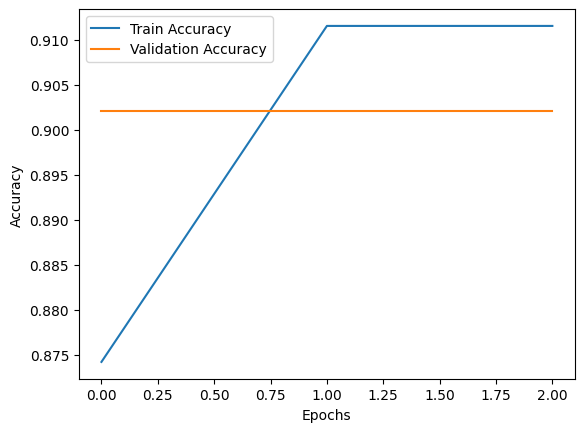

In [22]:
#Visualise the training and validation loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
